# Motivation
I'm going to try and collect a number of "utility functions" - these are Python functions that'll help me run various custom operations, like Prompt Graph. 

# Setup
The cells below will set up the rest of this notebook.

We'll start with some import statements.

In [1]:
# Import statements
import torch
import open_clip
import json
import shutil
import os
import subprocess
import scipy
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import plotly.express as px
from PIL import Image
from pathlib import Path
from natsort import os_sorted
from tqdm import tqdm
from IPython.display import display
from datetime import datetime
from scipy.spatial.distance import cosine 

D:\ProgramFiles\anaconda3\envs\ldm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next, we'll change our working directory to the root of the `stable-diffusion/` folder - this'll help us emulate the environment the `prompt-graph-utils.py` file will be run from. 

In [2]:
%cd ..

D:\Personal-Study\Programming\sd-prompt-graph\stable-diffusion


Finally, we're going to load in the OpenCLIP model. 

In [3]:
# Load in the model used 
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')

# Methods

### Text-Related SD Generation

#### `txt_2_image()`

In [4]:
# This method will generate 
def txt_2_image(prompt, outdir=None, steps=55, height=512, width=512, seed=None, sample_amount=1, 
                file_name=None, latent_json_output_path=None, print_command=False, 
                return_latent_ndarray=True, return_pixels=False,
                display_image=False, delete_img=False, delete_latent_json=False, turbo=True):
    
    # Generate the command 
    outdir_str = f'--outdir "{outdir}"' if outdir is not None else ""
    filename_str = f'--file-name "{file_name}"' if file_name is not None else ""
    latent_json_output_str = f'--latent-save-path "{latent_json_output_path}"' if latent_json_output_path is not None else ""
    seed_str = f'--seed {seed}' if seed is not None else ""
    command = f'python optimizedSD/optimized_txt2img.py --prompt "{prompt}" --H {height} --W {width} {seed_str} --n_samples {sample_amount} --ddim_steps {steps} {outdir_str} {filename_str} {latent_json_output_str} {"--turbo" if turbo else ""}'
    
    # Running the command
    if (print_command):
        print(f"Running the following command:\n{command}\n")
    subprocess.run(command)
    
    # Determine where the resulting image was output 
    if (outdir is not None and file_name is not None):
        resulting_img_file_path = Path(outdir) / Path(f"{file_name}.png")
        
        # Opening the image that was just created
        img = Image.open(resulting_img_file_path)
        img_pixels = np.array(img)

        # Delete the image if we need to 
        if (delete_img):
            os.remove(resulting_img_file_path)

        # Display the image if it was 
        if (display_image):
            display(img)
        
        # If we need to return the pixels, return them 
        if (return_pixels):
            return img_pixels
        
        # If we're returning the latent ndarray, we'll need to load it 
        if (return_latent_ndarray and latent_json_output_path is not None):
            with open(latent_json_output_path, "r") as json_file:
                latent_ndarray = np.asarray(json.load(json_file))
                
            if (delete_latent_json):
                os.remove(latent_json_output_path)
            return latent_ndarray

#### `txt_latent_path_2_image()`

In [5]:
# This method will generate 
def txt_latent_path_2_image(txt_latent_path, outdir=None, file_name=None, steps=55, height=512, width=512, seed=None, sample_amount=1, 
                            print_command=False, return_latent_ndarray=True, return_pixels=False, display_image=False, 
                            delete_img=False, turbo=True, return_filename=False, return_clip_embedding=False):
    
    # Generate the command 
    outdir_str = f'--outdir "{outdir}"' if outdir is not None else ""
    filename_str = f'--file-name "{file_name}"' if file_name is not None else ""
    # latent_json_output_str = f'--latent-save-path "{latent_json_output_path}"' if latent_json_output_path is not None else ""
    seed_str = f'--seed {seed}' if seed is not None else ""
    command = f'python optimizedSD/prompt-graph-txt2latent.py --latent-json-path "{txt_latent_path}" --H {height} --W {width} {seed_str} --n_samples {sample_amount} --ddim_steps {steps} {outdir_str} {filename_str} {"--turbo" if turbo else ""}'
    
    # Running the command
    if (print_command):
        print(f"Running the following command:\n{command}\n")
    subprocess.run(command)
    
    # Determine where the resulting image was output 
    if (outdir is not None and file_name is not None):
        resulting_img_file_path = Path(outdir) / Path(f"{file_name}.png")
        
        # Opening the image that was just created
        img = Image.open(resulting_img_file_path)
        img_pixels = np.array(img)

        # Delete the image if we need to 
        if (delete_img):
            os.remove(resulting_img_file_path)

        # Display the image if it was 
        if (display_image):
            display(img)
            
        if (return_filename):
            return resulting_img_file_path
        
        if (return_clip_embedding):
            return image_path_to_clip_embedding(resulting_img_file_path)
        
        # If we need to return the pixels, return them 
        if (return_pixels):
            return img_pixels
        
        # If we're returning the latent ndarray, we'll need to load it 
        if (return_latent_ndarray):
            with open(txt_latent_path, "r") as json_file:
                latent_ndarray = np.asarray(json.load(json_file))
            return latent_ndarray

#### `txt_latent_ndarray_2_image()`

In [6]:
def txt_latent_ndarray_2_image(latent_ndarray, outdir=None, file_name=None, steps=55, height=512, width=512, seed=None, sample_amount=1, 
                               print_command=False, return_latent_ndarray=False, return_pixels=False, display_image=False, 
                               delete_img=False, turbo=True, return_filename=False, return_clip_embedding=False):
    
    output_latent_path = f"outputs/temp_txt_latent_{int(datetime.now().timestamp())}.json"
    with open(output_latent_path, "w") as json_file:
        json.dump(latent_ndarray.tolist(), json_file)

    # Now, run the command
    return_val = txt_latent_path_2_image(output_latent_path, outdir=outdir, file_name=file_name, steps=steps, height=height, width=width, seed=seed, sample_amount=sample_amount, 
                            print_command=print_command, return_latent_ndarray=return_latent_ndarray, return_pixels=return_pixels, 
                            display_image=display_image, delete_img=delete_img, turbo=turbo, return_filename=return_filename,
                                         return_clip_embedding=return_clip_embedding)

    # Remove the temporary latent
    os.remove(output_latent_path)
    
    return return_val

### Image-Related SD Generation

#### `img_folder_2_latents()`

In [7]:
def img_folder_2_latents(img_folder, outdir=None, turbo=True,
                         delete_folder=True, return_ndarray_dict=True):
    
    # Craft the command that we're going to run 
    outdir_str = f'--outdir "{outdir}"' if outdir is not None else ""
    command = f"""python .\optimizedSD\prompt-graph-img2latent.py --latent-from-img-folder "{img_folder}" {outdir_str} {'--turbo' if turbo else ""} """
    
    # Run the command
    subprocess.run(command)
    
    # Figure out where the latent .json was output to 
    latent_json_folder_name = "img_latents"
    if outdir is None:
        latent_json_folder_path = Path("outputs/img2img-samples/") / Path(latent_json_folder_name)
    else:
        latent_json_folder_path = Path(outdir) / Path(latent_json_folder_name)
    
    
    # If the return_ndarray flag is set, we're going to return a dictionary keyed by stem with the ndarrays
    if (return_ndarray_dict):
        ndarray_dict = {}
        for file in latent_json_folder_path.iterdir():
            if (file.suffix == ".json"):
                with open(file, "r") as json_file:
                    latent_list = json.load(json_file)
                    ndarray_dict[file.stem] = np.asarray(latent_list)
                    
        # If we want to delete the folder, we ought to do that 
        if (delete_folder):
            shutil.rmtree(latent_json_folder_path)
            
        # Return the ndarray_dict
        return ndarray_dict

#### `img_2_latent`

In [8]:
# This method will run the img2latent script
def img_2_latent(img_path, outdir=None, name=None, turbo=True,
                 delete_file=True, return_ndarray=False):
    
    # Craft the command that we're going to run 
    outdir_str = f'--outdir "{outdir}"' if outdir is not None else ""
    name_str = f'--name "{name}"' if name is not None else ""
    command = f"""python .\optimizedSD\prompt-graph-img2latent.py --latent-from-img "{img_path}" {outdir_str} {name_str} {'--turbo' if turbo else ""} """
    
    # Run the command
    subprocess.run(command)
    
    # If the return_ndarray flag is set, we're going to return the ndarray
    if (return_ndarray):
        
        # Figure out where the latent .json was output to 
        file_name = "latent2img_output.json"
        if (name is not None):
            file_name = f"{name}.json"
        if outdir is None:
            latent_json_path = Path("outputs/img2img-samples/") / Path(file_name)
        else:
            latent_json_path = Path(outdir) / Path(file_name)
            
        # Read in the latent JSON
        with open(latent_json_path, "r") as json_file:
            latent_list = json.load(json_file)
            latent_ndarray = np.asarray(latent_list)
            
        # Check to see if we need to delete the latent array 
        if (delete_file):
            os.remove(latent_json_path)
            
        # Return the latent ndarray
        return latent_ndarray

#### `latent_2_img()`

In [9]:
# This method will run the latent_2_img script
def latent_2_img(latent_path=None, img_latent_ndarray=None, outdir=None, name=None, turbo=True,
                 return_pixels=False, return_path=False, display_image=False, delete_file=False):
    
    # If the user didn't input an image path, and instead directly passed a latent in ndarray form, 
    # then we'll temporarily save this to a .json file 
    if (img_latent_ndarray is not None):
        with open("outputs/temp_img_latent.json", "w") as json_file:
            json.dump(img_latent_ndarray.tolist(), json_file)
        latent_path = "outputs/temp_img_latent.json"
    
    # Craft the command that we're going to run 
    outdir_str = f'--outdir "{outdir}"' if outdir is not None else ""
    name_str = f'--name "{name}"' if name is not None else ""
    command = f"""python .\optimizedSD\prompt-graph-latent2img.py --img-latent "{latent_path}" {outdir_str} {name_str} {'--turbo' if turbo else ""} """
    
    # Run the command
    subprocess.run(command)
    
    # If the temporary image latent was saved, we'll want to delete it 
    if (img_latent_ndarray is not None):
        os.remove(latent_path)
    
    # Figure out where the resulting image was created
    file_name = "latent2img_outputImg.png"
    if (name is not None):
        file_name = f"{name}.png"
    if outdir is None:
        latent_img_path = Path("outputs/img2img-samples/") / Path(file_name)
    else:
        latent_img_path = Path(outdir) / Path(file_name)
        
    # Opening the image that was just created
    img = Image.open(latent_img_path)
    img_pixels = np.array(img)
    
    # Delete the image if we need to 
    if (delete_file):
        os.remove(latent_img_path)
    
    # Display the image if it was 
    if (display_image):
        display(img)
    
    # If return pixels is True, we're going to load in the new image
    if (return_pixels):
        return img_pixels
    
    if (return_path):
        return latent_img_path

#### `img_path_list_to_latents()`

In [10]:
# This method will take a path of lists and return a dictionary of image latents keyed by "filename stem".
# (TODO: Fix a bug in this where two images of the same name override eachother in the dictionary.)
# This bug happens because I'm using file stems in the dictionary instead of full paths
def img_path_list_to_latents(img_path_list):
    
    # We're first going to set up a temporary folder for these images
    timestamp_suffix = str(int(datetime.utcnow().timestamp()))
    img_tmp_folder_path = Path(f"outputs/tmp_img_folder_{timestamp_suffix}")
    if (img_tmp_folder_path.exists()):
        shutil.rmtree(img_tmp_folder_path)
    img_tmp_folder_path.mkdir(exist_ok=True, parents=True)

    # Now, we'll copy each of the images in the img_path_list to the temporary folder
    for img_path in img_path_list:
        new_path = img_tmp_folder_path / Path(img_path).name
        shutil.copyfile(img_path, new_path)

    # Next, we're going to run the img_folder_2_latents method 
    ndarray_dict = img_folder_2_latents(img_tmp_folder_path, 
                                        delete_folder=True, return_ndarray_dict=True)
    
    # Finally, we'll delete the img_tmp_folder_path now that we're done with it 
    shutil.rmtree(img_tmp_folder_path)

    # Finally, we'll return this information 
    return ndarray_dict

### Latent Computation

#### `average_img_latents_from_path_list()`

In [11]:
# This method will average together the latents of the images whose paths are in img_file_path_list,
# and return this "average latent" as an ndarray
def average_img_latents_from_path_list(img_file_path_list):
    
    # We're going to store the latents in this dictionary 
    img_latents_by_stem_dict = {}
    
    # We're going to store the latents in this dictionary 
    img_latents_by_stem_dict = img_path_list_to_latents(img_file_path_list)

    # Create the "average" of the latents 
    return np.mean([ndarray for stem, ndarray in img_latents_by_stem_dict.items()], axis=0)

#### `average_img_latents_from_img_folder()`

In [12]:
def average_img_latents_from_img_folder(img_folder_path):
    return average_img_latents_from_path_list(
        [file for file in Path(img_folder_path).iterdir() if file.suffix == ".png"])

### Various Utilites

#### `change_in_filesize_paths()`

In [13]:
# This method will calculate the change in filesize between two image files
def change_in_filesize_paths(file_1_path, file_2_path):
    
    # Make sure that both of the inputs are Path objects
    file_1_path = Path(file_1_path)
    file_2_path = Path(file_2_path)
    
    # Now, grab the filesizes 
    file_1_size = file_1_path.stat().st_size
    file_2_size = file_2_path.stat().st_size
    
    # Get the absolute value of their difference, and compare it to file_1_size
    filesize_diff_abs = abs(file_1_size - file_2_size)
    return filesize_diff_abs/file_2_size

#### `change_in_filesize()`

In [14]:
# This method will calculate the change in filesize between two image files
def change_in_filesize(file_1_size, file_2_size):
    
    # Get the absolute value of their difference, and compare it to file_1_size
    filesize_diff_abs = abs(file_1_size - file_2_size)
    return filesize_diff_abs/file_2_size

#### `change_in_pixels_paths()`

In [15]:
# This method will calculate the change in pixel-space between two images 
def change_in_pixels_paths(file_1_path, file_2_path):
    
    # Make sure that both of the inputs are Path objects
    file_1_path = Path(file_1_path)
    file_2_path = Path(file_2_path)
    
    # Load the images into pixel arrays
    file_1_pixels = np.asarray(Image.open(file_1_path))
    file_2_pixels = np.asarray(Image.open(file_2_path))

    # Now, calculate the difference in norm 
    return np.linalg.norm(file_1_pixels-file_2_pixels)/np.linalg.norm(file_1_pixels)

#### ```change_in_pixels()```

In [16]:
# This method will calculate the change in pixel-space between two images 
def change_in_pixels(file_1_pixels, file_2_pixels):

    # Now, calculate the difference in norm 
    return np.linalg.norm(file_1_pixels-file_2_pixels)/np.linalg.norm(file_1_pixels)

#### `change_in_latents_paths()`

In [17]:
# This method will calculate the change in latent-space between two images
def change_in_latents_paths(file_1_path, file_2_path):
    
    # Use CLIP to grab the latents 
    path_stem_to_latents_dict = img_path_list_to_latents([file_1_path, file_2_path])
    
    # Make sure that both of the inputs are Path objects
    file_1_path = Path(file_1_path)
    file_2_path = Path(file_2_path)

    # Now, grab the latents from the path_stem_to_latents_dict
    file_1_latent = path_stem_to_latents_dict[file_1_path.stem]
    file_2_latent = path_stem_to_latents_dict[file_2_path.stem]

    # Return the difference
    return np.linalg.norm(file_1_latent-file_2_latent)/np.linalg.norm(file_1_latent)

#### `change_in_latents()`

In [18]:
# This method will calculate the change in latent-space between two images
def change_in_latents(file_1_latent, file_2_latent):

    # Return the difference
    return np.linalg.norm(file_1_latent-file_2_latent)/np.linalg.norm(file_1_latent)

#### CLIP Embedding

In [32]:
# This method will take in a path to an image and return the CLIP embedding of that image
def image_path_to_clip_embedding(img_path):
    
    # Running this image through the CLIP pre-processor
    image = preprocess(Image.open(img_path)).unsqueeze(0)

    # Using CLIP to encode the image into a vector
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
    # Return the image features
    return image_features[0]

# This method will take in a list of image paths and return a dictionary (keyed by path stem)
# of all of the CLIP embeddings for the images
def image_path_list_to_clip_embedding_dict(img_path_list):
    
    # Create the dictionary we're going to return
    img_embedding_dict = {}
    
    # Ensure that all of the paths in the img_path_list are Path objects
    img_path_list = [Path(path) for path in img_path_list]
    
    # Iterate through each path, and calculate the CLIP embedding
    for path in img_path_list:
        img_embedding_dict[path.stem] = image_path_to_clip_embedding(path)
        
    # Return the dictionary
    return img_embedding_dict

# This method will calculate the cosine distance between two CLIP embeddings
def change_in_clip_embedding(emb1, emb2):
    return cosine(emb1, emb2)

# This method will calculate the cosine distance between two CLIP embeddings (when given the paths of the images)
def change_in_clip_embedding_paths(path1, path2):
    emb1 = image_path_to_clip_embedding(path1)
    emb2 = image_path_to_clip_embedding(path2)
    return change_in_clip_embedding(emb1, emb2)

### Prompt-Graph
These utilities are directly related to prompt graph. 

#### `prompt_info_for_frame()`

In [20]:
# This method will generate a prompt for a particular frame from a configuration file
def prompt_info_for_frame(frame, config):
    
    # Create a "prompt_key_to_text_prompt" dictionary
    prompt_key_to_text_prompt = {prompt_info["key"]: prompt_info["prompt"] for prompt_info in config["prompts"]}
    prompt_strength_by_frame = config["prompt_strength_by_frame"]
    
    # Iterate through the prompts to see which ones have non-null strengths
    prompt_keys_to_use = []
    for prompt_info in config["prompts"]:
        key = prompt_info["key"]
        if (prompt_strength_by_frame[str(frame)][str(key)] is not None):
            prompt_keys_to_use.append(key)
            
    # If we didn't find any prompts w/ strengths associated with this frame, return None
    if (not prompt_keys_to_use):
        return None
            
    # Now, for each of the keys in the prompt key, we're going to 
    final_prompt = " ".join([f"{prompt_key_to_text_prompt[key].strip()}:{str(prompt_strength_by_frame[str(frame)][str(key)])}"
        for key in prompt_keys_to_use])
    return final_prompt

#### `rename_pics_in_folder_monotonically()`

In [21]:
# This method will rename all of the pictures in a folder so that they're monotonically increasing from 0 based on alphabetical order
def rename_pics_in_folder_monotonically(folder_path, prefix="", stopping_point=None, rename_clip_latent=False):
    
    # Make sure this folder is a Path object
    folder_path = Path(folder_path)
    
    # Iterate through each file in the folder, and collect their names 
    img_stems = []
    for file_path in folder_path.iterdir():
        if (file_path.suffix == ".png"):
            img_stems.append(file_path.stem)

    # Sort them 
    img_stems = os_sorted(img_stems)
    if (stopping_point is not None):
        img_stems=img_stems[:stopping_point+1]
        print(img_stems)
    
    # Now, we're going to rename all of the files twice. The first time, we're going to rename them all 
    rename_addition = len(img_stems)+1
    for idx, stem in enumerate(img_stems):

        # Grab the file at this index
        cur_file = folder_path / Path(f"{stem}.png")
        new_path = folder_path / Path(f"{prefix}{idx+rename_addition}.png")
        os.rename(cur_file, new_path)
        
        if (rename_clip_latent):
            cur_file_new = folder_path / Path("latent_json_folder") / Path(f"latent_json_{stem}.json")
            new_path_new = folder_path / Path("latent_json_folder") / Path(f"{prefix}latent_json_{idx+rename_addition}.json")
            os.rename(cur_file_new, new_path_new)
        
    for num in range(rename_addition, len(img_stems)+rename_addition):
        
        # Grab the file at this index
        cur_file = folder_path / Path(f"{prefix}{num}.png")
        new_path = folder_path / Path(f"{prefix}{num-rename_addition}.png")
        os.rename(cur_file, new_path)
        
        if (rename_clip_latent):
            cur_file = folder_path / Path("latent_json_folder") / Path(f"{prefix}latent_json_{num}.json")
            new_path = folder_path / Path("latent_json_folder") / Path(f"{prefix}latent_json_{num-rename_addition}.json")
            os.rename(cur_file, new_path)

#### `launch_config_generation()`

In [36]:
# This method will launch a configuration from a given filepath
def launch_config_generation(config_file_path, steps=55, height=512, width=512, seed=1,
                             save_prompt_strength_plot=True, save_image_change_plot=True,
                             image_change_plot_distance_metric="clip_embeddings"):
    
    # Open the configuration file 
    with open(config_file_path, "r") as json_file:
        config = json.load(json_file)

    # Save the actual configuration file
    config_file_save_path_folder = Path(f"outputs\\txt2img-samples\\{config['filename']}")
    config_file_save_path_folder.mkdir(exist_ok=True, parents=True)
    with open(f'{config_file_save_path_folder}/config.json', "w") as json_file:
        json.dump(config, json_file, indent=2)
    
    config["filename"] = f"outputs\\txt2img-samples\\{config['filename']}"
    
    # Create a folder for the latent JSONs within this new folder
    latent_json_folder = Path(config["filename"]) / Path("latent_json_folder")
    latent_json_folder.mkdir(exist_ok=True, parents=True)

    # Iterate through each frame and generate the image corresponding with it
    for frame in tqdm(range(int(config["frame_amt"]))):

        # Generate the prompt for this frame
        frame_prompt = prompt_info_for_frame(frame, config)

        # If the frame_prompt is a valid string, run the generation for this frame
        if (frame_prompt):
            txt_2_image(frame_prompt, outdir=config["filename"], steps=steps, height=height, width=width, seed=seed, 
                        file_name=str(frame), latent_json_output_path=f'{latent_json_folder}/latent_json_{frame}.json')
            
    # Now that we're at the end of the loop, we can rename everything
    rename_pics_in_folder_monotonically(Path(config["filename"]), rename_clip_latent=True)
    
    # If the save_prompt_strength_plot flag is True, then we'll save the prompt strength image 
    if (save_prompt_strength_plot):
        
        # Generate the Plotly figure 
        plotly_fig = generate_prompt_graph_image(config)
        
        # Determine what the filepath is 
        file_path = Path(config["filename"]) / Path("Prompt Strength Graph.png")
        
        # Save the Plotly figure that was just created 
        plotly_fig.write_image(file_path, format="png", scale=3)
        
    # If the save_image_change_plot flag is True, then we'll save the image difference plot
    if (save_image_change_plot):
        
        # Generate the prompt graph image difference figure
        plotly_fig = generate_prompt_graph_image_difference_plotly_fig(Path(config["filename"]), 
                                                                       distance_method=image_change_plot_distance_metric)
        
        # Determine what the filepath is 
        file_path = Path(config["filename"]) / Path("Frame to Frame Difference Graph.png")
        
        # Now, save the Plotly figure that was just created
        plotly_fig.write_image(file_path, format="png", scale=3)
            
    # Return the folder where we output all of the files
    return config["filename"]

#### `recursive_latent_interpolation()`

In [23]:
# Indicate the different methods we're going to use to calculate distance
distance_metric_keys = {"filesize_paths": change_in_filesize_paths,
                        "filesize": change_in_filesize,
                        "pixels_paths": change_in_pixels_paths,
                        "pixels": change_in_pixels,
                        "latents_paths": change_in_latents_paths,
                        "latents": change_in_latents,
                        "clip_embeddings_paths": change_in_clip_embedding_paths,
                        "clip_embeddings": change_in_clip_embedding}

# Set up a stub for the method 
def recursive_latent_interpolation(left_filename, right_filename, left_latent, right_latent, 
                                   left_measure=None, right_measure=None, direction="l", early_stop=4, 
                                   pct_change_threshold=0.3, distance_metric="latents", seed=1):

    # ========================================================================
    # Miscellaneous setup steps
    # ========================================================================
    # Make sure both the left_filename and right_filename are Paths 
    left_filename = Path(left_filename)
    right_filename = Path(right_filename)

    # ========================================================================
    # Check if we're at an early stopping point
    # ========================================================================
    # Stop the recursion if we're at an early stopping point 
    if (early_stop is not None and early_stop <= 0):
        return 

    # ========================================================================
    # Generate a new filename for the new image
    # ========================================================================
    new_filename = f"new"
    if (left_filename.stem.isnumeric() and right_filename.stem.isnumeric()):
        new_filename = left_filename.stem + f"_{early_stop}#m"
    else:
        letter_to_add = "a" if direction == "left" else "b"
        pair_to_add = f"{early_stop}#{letter_to_add}"
        bigger_filename = left_filename.stem
        if (len(right_filename.stem) > len(bigger_filename)):
            bigger_filename = right_filename.stem
        split_bigger_filename = bigger_filename.split("_")

        # Deal with the instance where our direction is "left"
        if (direction == "left"):
            split_bigger_filename.insert(1, pair_to_add)
        elif (direction == "right"):
            split_bigger_filename.append(pair_to_add)

        # Generate the new filename 
        new_filename = "_".join(split_bigger_filename)

    # ========================================================================
    # Launch the new generation 
    # ========================================================================

    # Generate an intermediate latent 
    intermediate_latent = np.mean([left_latent, right_latent], axis=0)
    
    # Now, we'll want to save this intermediate latent to the folder with the latents
    intermediate_latent_path = left_filename.parent / Path("latent_json_folder") / Path(f"latent_json_{new_filename}.json")
    with open(intermediate_latent_path, "w") as json_file:
        json.dump(intermediate_latent.tolist(), json_file)

    # Run image generation on this intermediate latent 
    mid_measure = txt_latent_ndarray_2_image(intermediate_latent, outdir=left_filename.parent, file_name=new_filename,
                               display_image=False, delete_img=False, seed=seed, 
                               return_latent_ndarray = distance_metric=="latents",
                               return_pixels = distance_metric=="pixels",
                               return_filename = distance_metric=="filesize",
                                            return_clip_embedding = distance_metric=="clip_embeddings")
    if (distance_metric == "filesize"):
        mid_measure = Path(mid_measure).stat().st_size

    mid_filename = Path(left_filename.parent) / Path(new_filename+".png")

    # ========================================================================
    # Calculate the new distance (depending on distance_metric and direction)
    # ========================================================================

    # Determine which two things we're using 
    if (direction == "left"):
        new_left_measure = left_measure
        new_right_measure = mid_measure
        new_left_filepath = left_filename
        new_right_filepath = mid_filename
        new_left_latent = left_latent
        new_right_latent = intermediate_latent
    elif (direction == "right"):
        new_left_measure = mid_measure
        new_right_measure = right_measure
        new_left_filepath = mid_filename
        new_right_filepath = right_filename
        new_left_latent = intermediate_latent
        new_right_latent = right_latent


    # Determine the distance between the new image and one of the side images depending on 
    # the direction, the distance metric, and whether the measure was provided
    if (new_left_measure is not None and new_right_measure is not None):
        distance_function = distance_metric_keys[distance_metric]
        new_distance = distance_function(new_left_measure, new_right_measure)
    else:
        distance_function = distance_metric_keys[distance_metric + "_paths"]
        new_distance = distance_function(new_left_filepath, new_right_filepath)


    # If the percent change between the 
    if (new_distance > pct_change_threshold):
        recursive_latent_interpolation(new_left_filepath, new_right_filepath, new_left_latent, new_right_latent, 
                                       left_measure=new_left_measure, right_measure=new_right_measure, direction=direction, 
                                       early_stop=early_stop-1, pct_change_threshold=pct_change_threshold, 
                                       distance_metric=distance_metric, seed=seed)
        
    # Return the midpoint filename
    return mid_filename, mid_measure, intermediate_latent

#### `prompt_graph_back_and_forth_recursion()`
This method will perform leftwards and rightwards recursive latent interpolation on each of the images in a Prompt Graph output folder.

In [37]:
# This method will perform the back and forth recursion
def prompt_graph_back_and_forth_recursion(prompt_graph_output_folder, loops=1, 
                                          pct_change_threshold=0.3, early_stop=4,
                                          seed=1,
                                          distance_metric="clip_embeddings",
                                          new_folder_suffix="smoother_interpolations",
                                          save_image_change_plot=True):
    
    # Ensure that prompt_graph_output_folder is a Path
    prompt_graph_output_folder = Path(prompt_graph_output_folder)

    # Make a copy of this folder that 
    prompt_graph_output_folder_parent = prompt_graph_output_folder.parent
    new_output_folder = prompt_graph_output_folder_parent / Path(f"{prompt_graph_output_folder.stem}_{new_folder_suffix}")
    if (new_output_folder.exists()):
        shutil.rmtree(new_output_folder)
    shutil.copytree(prompt_graph_output_folder, new_output_folder)

    # Run through each of the loops
    for loop in range(loops):

        # Grab all of the .png paths in new_output_folder
        file_path_list = os_sorted([path for path in list(new_output_folder.iterdir()) if path.suffix == ".png"])

        # Load in the latents for all of these images 
        latents_by_stem_dict = {}
        for path in [Path(f'{str(new_output_folder / Path("latent_json_folder"))}/latent_json_{path.stem}.json')
                     for path in file_path_list]:
            with open(path, "r") as json_file:
                latents_by_stem_dict[path.stem.split("_")[-1]] = np.asarray(json.load(json_file))

        # Iterate through each of the files in the file_path_list, and run recursive_latent_interpolation
        for idx, right_filename in tqdm(list(enumerate(file_path_list))):
            if (idx == 0): continue

            # Grab the left filename
            left_filename = file_path_list[idx-1]

            # Grab the CLIP latents for each of the files
            left_latent = latents_by_stem_dict[left_filename.stem]
            right_latent = latents_by_stem_dict[right_filename.stem]

            # Grab the mesures of each of the files
            if (distance_metric == "latents"):
                left_measure = left_latent
                right_measure = right_latent
            elif (distance_metric == "pixels"):
                left_measure = np.asarray(Image.open(left_filename))
                right_measure = np.asarray(Image.open(right_filename))
            elif (distance_metric == "filesize"):
                left_measure = left_filename.stat().st_size
                right_measure = right_filename.stat().st_size
            elif (distance_metric == "clip_embeddings"):
                left_measure = image_path_to_clip_embedding(left_filename)
                right_measure = image_path_to_clip_embedding(right_filename)

            # Now, grab the percent change between the left and the right measures
            distance_function = distance_metric_keys[distance_metric]
            pct_change = distance_function(left_measure, right_measure)

            # If the change between this image and the previous one is higher than the threshold, run recursion
            if (pct_change > pct_change_threshold):

                # Run the recursive latent interpolation in the leftwards direction
                mid_filename, mid_measure, mid_latent = recursive_latent_interpolation(
                    left_filename, right_filename, left_latent, right_latent, 
                    left_measure=left_measure, right_measure=right_measure, direction="left", 
                    early_stop=early_stop, pct_change_threshold=pct_change_threshold, 
                    distance_metric=distance_metric, seed=seed)

                # Now, check to see if the distance between the mid and right files is bigger than the pct_change 
                mid_pct_change = distance_function(mid_measure, right_measure)

                # If the mid_pct_change is greater than the threshold, we're going to run rightwards recursion
                if (mid_pct_change > pct_change_threshold):

                    # Run the recursive latent interpolation in the rightwards direction
                    right_mid_filename, right_mid_measure, right_mid_latent = recursive_latent_interpolation(
                        mid_filename, right_filename, mid_latent, right_latent, 
                        left_measure=mid_measure, right_measure=right_measure, direction="right", 
                        early_stop=early_stop, pct_change_threshold=pct_change_threshold, 
                        distance_metric=distance_metric, seed=seed)
                    
        # Now that we're at the end of the loop, we can rename everything
        rename_pics_in_folder_monotonically(new_output_folder, rename_clip_latent=True)
        
    # If the save_image_change_plot flag is True, then we'll save the image difference plot
    if (save_image_change_plot):
        
        # Generate the prompt graph image difference figure
        plotly_fig = generate_prompt_graph_image_difference_plotly_fig(Path(new_output_folder), 
                                                                       distance_method=distance_metric)
        
        # Determine what the filepath is 
        file_path = Path(new_output_folder) / Path("Frame to Frame Difference Graph.png")
        
        # Now, save the Plotly figure that was just created
        plotly_fig.write_image(file_path, format="png", scale=3)

#### `generate_prompt_graph_animation()`
The following method will create an animation from some prompt graph output folder.

In [25]:
# This method will create an animation at a given FPS from a Prompt Graph folder
def generate_prompt_graph_animation(image_folder, fps=5):
    
    # Now, create the output file name
    output_file_name = f"animation_{fps}_fps.mp4"
    output_file_path = Path(image_folder) / Path(output_file_name)

    # Generate the FFMPEG command
    command = f"ffmpeg -r {fps} -s 1280x720 -f image2 -i \"{image_folder}\%d.png\" -vcodec libx264 -crf 25  -pix_fmt yuv420p -r {fps} \"{output_file_path}\""

    # Print and run the FFMPEG command 
    subprocess.run(command)

### Graphing Related Methods
These methods specifically involve using Plotly to create graphs. 

#### `config_to_prompt_strength_df()`
This method is a "helper" method for the `generate_prompt_graph_image()` method.

In [26]:
# This method will create a prompt_strength_df 
def config_to_prompt_strength_df(config):
    
    # First, we'll create a dictionary of prompt key --> info for each of the prompts
    prompt_key_to_prompt_info = {prompt_info["key"]: prompt_info for prompt_info in config["prompts"]}

    # We're going to create a DataFrame out of these prompt_line_df_records.
    prompt_line_df_records = []
    for frame, prompt_key_to_strength in config["prompt_strength_by_frame"].items():

        # Check if there are non-null values in the prompt_key_to_strength dictionary
        if ([x for x in [strength for prompt_key, strength in prompt_key_to_strength.items()] if x is not None]):

            # Add a record for each of the non-null prompts
            for key, strength in {int(prompt_key):float(strength) for 
                                         prompt_key, strength in prompt_key_to_strength.items() 
                                         if strength is not None}.items():

                # Create a record for this (prompt, strength) instance
                cur_prompt_strength_record = {
                    "key": key,
                    "prompt": prompt_key_to_prompt_info[key]["prompt"],
                    "strength": strength,
                    "color": prompt_key_to_prompt_info[key]["color"],
                    "frame": int(frame)
                }

                # Now, add this record to the prompt_line_df_records list 
                prompt_line_df_records.append(cur_prompt_strength_record)

    # Create the DataFrame and return it
    prompt_strength_df = pd.DataFrame.from_records(prompt_line_df_records)
    prompt_strength_df["frame"] = prompt_strength_df["frame"] - prompt_strength_df["frame"].min()
    return prompt_strength_df

#### `generate_prompt_graph_plotly_fig()`

This method will create a Plotly figure that contains the prompt strengths contained within a configuration file.

In [27]:
# This method will save the configuration image 
def generate_prompt_graph_plotly_fig(config):
    
    # Grab the prompt_strength_df 
    prompt_strength_df = config_to_prompt_strength_df(config)
    
    # Truncate the prompts (better labelling)
    # This method will insert "<br>" into a string after every 100 characters
    def break_string_into_lines_plotly(my_str, line_max_length=80):
        lines = []
        cur_line = ""
        split_str = my_str.split(" ")
        for token in split_str:
            if len(cur_line + f" {token}") <= line_max_length:
                cur_line = cur_line + f" {token}"
            else:
                lines.append(cur_line.strip())
                cur_line = token
        lines.append(cur_line.strip())
        breaked_lines = "<br>".join(lines)
        return breaked_lines
    n = 130
    prompt_strength_df["prompt"] = prompt_strength_df["prompt"].apply(lambda x: break_string_into_lines_plotly(x, n))
    line_ct = len(prompt_strength_df["prompt"].unique()) + "".join(list(prompt_strength_df["prompt"].unique())).count("<br>")
    y_offset = (line_ct * 19)/600
    
    # Create the figure
    fig = px.line(prompt_strength_df, x="frame", y="strength", color="prompt",
                  title=f"Prompt Graph - '{config['filename']}'",
                  labels={"strength": "Prompt Strength", "frame": "Animation Frame", "prompt": "Prompt"},
                  height=600)

    # Stylize the figure
    fig.update_xaxes(nticks=10, range=[0, prompt_strength_df["frame"].max()])
    fig.update_layout(legend=dict(
        orientation="h",
        y=-1*y_offset,
        xanchor="left",
        x=0,
        title={"text": None}
    ))
        
    return fig

#### `generate_prompt_graph_image_difference_plotly_fig()`

In [34]:
# This method will generate the "change over time" figure 
def generate_prompt_graph_image_difference_plotly_fig(path_to_img_folder, distance_method="latents"):
    
    # Make sure that the path_to_img_folder is a Path object 
    path_to_img_folder = Path(path_to_img_folder)
    
    # We're going to create a DataFrame out of some of the information we extract from the files
    file_info_df_records = []

    # Iterating through each of the files
    for file_path in path_to_img_folder.iterdir():

        # Look for .png files
        if (file_path.suffix != ".png"): continue

        # Grab the "frame number" that this file represents
        frame_number = int(file_path.stem)

        # Add this information to the records list
        file_info_df_records.append({
            "file_path": str(file_path),
            "frame_num": frame_number,
        })

    # Create a DataFrame from the records we'd created 
    file_info_df = pd.DataFrame(file_info_df_records).sort_values("frame_num")

    # Create the "measure" field within the file_info_df; creating this will depend on which distance metric we're using
    if distance_method == "filesize": 
        file_info_df["measure"] = file_info_df["file_path"].apply(lambda x: Path(x).stat().st_size)
    elif distance_method == "pixels": 
        file_info_df["measure"] = file_info_df["file_path"].apply(lambda x: np.asarray(Image.open(x)))
    elif distance_method == "latents":
        img_path_list = list(file_info_df["file_path"])
        img_latent_dict = img_path_list_to_latents(img_path_list)
        img_latent_list = []
        for path in img_path_list:
            img_latent_list.append(img_latent_dict[Path(path).stem])
        file_info_df["measure"] = img_latent_list
    elif distance_method == "clip_embeddings":
        img_latent_dict = image_path_list_to_clip_embedding_dict(list(file_info_df["file_path"]))
        file_info_df["measure"] = [img_latent_dict[Path(path).stem] for path in img_latent_dict]

    # Now, create the "difference between last frame" field
    diff_between_last_frame = []
    for idx, row in enumerate(list(file_info_df.itertuples())):
        if row.frame_num == 0:
            diff_between_last_frame.append(0)
        else:
            prev_frame = file_info_df.query("frame_num==@row.frame_num-1").iloc[0]
            diff_between_last_frame.append(distance_metric_keys[distance_method](row.measure, prev_frame.measure))
    file_info_df["change_between_frames"] = diff_between_last_frame

    # Finally, create the Plotly figure 
    file_size_diff_fig = px.bar(file_info_df.query("frame_num>0"), x="frame_num", y="change_between_frames", 
                                labels={"frame_num": "Frame", "change_between_frames": "Change From Previous Frame"})
    change_amt_dict = {"filesize": 1.1, "latents": 1.1, "pixels": 1.4, "clip_embeddings": 1.1}
    file_size_diff_fig.update_yaxes(range=[0, file_info_df["change_between_frames"].max()*change_amt_dict[distance_method]])
    
    # Return the figure 
    return file_size_diff_fig

# Testing Grounds
Below, I'm going to test out some of the different methods that I've written. This will ensure that they're all working correctly! 

### `txt_2_image()`

In [ ]:
latent = txt_2_image("cow:1 rainbow:1.5", outdir="outputs/", file_name="test",
                     return_latent_ndarray=True, display_image=True, delete_img=False, 
                     latent_json_output_path="outputs/latent_json.json")

### `txt_latent_ndarray_2_image()`

In [ ]:
txt_latent_ndarray_2_image(latent, outdir="outputs/", file_name="from_txt_latent_test",
                           display_image=True, delete_img=True, 
                           latent_json_output_path="outputs/latent_json_2.json")

### ```txt_latent_path_2_image()```

In [ ]:
# Save the 

In [ ]:
txt_latent_path_2_image(txt_latent_path, outdir=None, file_name=None, steps=55, height=512, width=512, seed=None, sample_amount=1, 
                       print_command=False, return_latent_ndarray=True, return_pixels=False, display_image=False, 
                       delete_img=False, turbo=True)

### `img2latent()`
Below, we're going to try and test the `img2latent()` method. This ought to take in the path to an image file and output a `.json` file that contains the latent. 

In [ ]:
# Set some parameters, and then run the img_2_latent() method
img_2_latent_test_path = "C:\\Data\\Personal Study\\Programming\\latent-clustering\\img_experiment_folders\\clip_sim_and_color_sim_interpolation\\5.png"
img_2_latent_outdir = "C:\\Data\\Personal Study\\Programming\\sd-prompt-graph\\stable-diffusion\\outputs\\img2img-samples\\8"
img_2_latent_name = "testName"
img_2_latent_ndarray = img_2_latent(img_2_latent_test_path, 
                                    outdir=img_2_latent_outdir, 
                                    name=img_2_latent_name, 
                                    return_ndarray=True,
                                    delete_file=False)

# Print the shape of the resulting latent in order to ensure that we'd correctly converted the image to a latent
print(f"The resulting latent has the following shape: {img_2_latent_ndarray.shape}")


### `img_folder_2_latents()`

In [ ]:
img_folder_2_latents_test_folder_path = "C:\\Data\\Personal Study\\Programming\\latent-clustering\\img_experiment_folders\\clip_sim_and_color_sim_interpolation"
ndarray_dict = img_folder_2_latents(img_folder_2_latents_test_folder_path, 
                                    delete_folder=True, return_ndarray_dict=True)

### `latent2img()`
Next, we'll try and test the latent2img() method. This will take in the path to an image latent and create an image.

In [ ]:
# Set some parameters, and then run the img_2_latent() method
latent_2_img_path = "C:\\Data\\Personal Study\\Programming\\sd-prompt-graph\\stable-diffusion\\outputs\\img2img-samples\\8\\testName.json"
latent_2_img_output_filepath = latent_2_img(latent_path=latent_2_img_path, return_path=True)

We can also try running the `latent_2_img()` method by directly passing an image as an ndarray. 

In [ ]:
latent_2_img_output_filepath = latent_2_img(img_latent_ndarray=img_2_latent_ndarray)

### `average_img_latents_from_path_list()`
This function is meant to combine the latents of multiple images when passed a list of image paths. It'll return the ndarray of the images. 

In [ ]:
# Create a list of images we want to "average" together
img_file_path_list = ["C:\\Data\\Personal Study\\Programming\\stable-diffusion\\stable-diffusion-basujindal\\outputs\\txt2img-samples\\donwood seed experiment\\135.png",
                      "C:\\Data\\Personal Study\\Programming\\stable-diffusion\\stable-diffusion-basujindal\\outputs\\txt2img-samples\\donwood seed experiment\\136.png"]

# Run the latent averaging
avg_latent_ndarray = average_img_latents_from_path_list(img_file_path_list)

Now that we've averaged these together, we can try and create the image from the resulting ndarray. 

In [ ]:
# Run latent_2_img, and display the resulting image. Delete the file itself once you're finished 
latent_2_img(img_latent_ndarray=avg_latent_ndarray, display_image=True, delete_file=False)

### `img_path_list_to_latents()`

In [ ]:
# Declare a list of image paths 
img_path_list_to_latents_test_path_list = [
    "C:\\Data\\Personal Study\\Programming\\latent-clustering\\img_experiment_folders\\clip_sim_and_color_sim_interpolation\\28.png",
    "C:\\Data\\Personal Study\\Programming\\latent-clustering\\img_experiment_folders\\clip_sim_and_color_sim_interpolation\\33.png",
    "C:\\Data\\Personal Study\\Programming\\stable-diffusion\\stable-diffusion-basujindal\\outputs\\txt2img-samples\\donwood seed experiment\\42.png"
]

# Now, grab the latents in a dictionary
img_path_to_latents_dict = img_path_list_to_latents(img_path_list_to_latents_test_path_list)

### `launch_config_generation()`

In [ ]:
config_path = "C:\\Users\\trevb\\Downloads\\Oh Uncertainty.json"
launch_config_generation(config_path)

### `change_in_filesize_paths()`

In [ ]:
file_1_path = "C:\\Data\\Personal Study\\Programming\\latent-clustering\\img_experiment_folders\\clip_sim_and_color_sim_interpolation\\28.png"
file_2_path = "C:\\Data\\Personal Study\\Programming\\latent-clustering\\img_experiment_folders\\clip_sim_and_color_sim_interpolation\\33.png"
change_in_filesize_paths(file_1_path, file_2_path)

In [ ]:
change_in_filesize(file_1_path, file_1_path)

### `change_in_pixels_paths()`

In [ ]:
change_in_pixels_paths(file_1_path, file_2_path)

In [ ]:
change_in_pixels_paths(file_2_path, file_1_path)

### `recursive_latent_interpolation()`
I'm going to test that the recursive latent interpolation function is working properly. 

In [ ]:
# Indicate some of the arguments 
early_stop = 5
pct_change_threshold = 0.25
direction = "left"
distance_metric = "latents"
seed = 1
left_measure = left_latent
right_measure = right_latent

# Indicating a couple of different pieces of info 
frame_1 = 6
frame_2 = 10
left_filename = Path(f"C:\\Data\\Personal Study\\Programming\\sd-prompt-graph\\stable-diffusion\\outputs\\txt2img-samples\\Oh Uncertainty\\{frame_1}.png")
right_filename = Path(f"C:\\Data\\Personal Study\\Programming\\sd-prompt-graph\\stable-diffusion\\outputs\\txt2img-samples\\Oh Uncertainty\\{frame_2}.png")
left_latent = txt_latent_path_2_image(f"C:\\Data\\Personal Study\\Programming\\sd-prompt-graph\\stable-diffusion\\outputs\\txt2img-samples\\Oh Uncertainty\\latent_json_{frame_1}.json",
                                      outdir=left_filename.parent, file_name=left_filename.stem, seed=seed)
right_latent = txt_latent_path_2_image(f"C:\\Data\\Personal Study\\Programming\\sd-prompt-graph\\stable-diffusion\\outputs\\txt2img-samples\\Oh Uncertainty\\latent_json_{frame_2}.json",
                                       outdir=right_filename.parent, file_name=right_filename.stem, seed=seed)

Now, we'll run the recursive latent interpolation! 

In [ ]:
recursive_latent_interpolation(left_filename, right_filename, left_latent, right_latent, 
                               left_measure=left_measure, right_measure=right_measure, direction="left", early_stop=early_stop, 
                               pct_change_threshold=pct_change_threshold, distance_metric=distance_metric, seed=seed)

recursive_latent_interpolation(left_filename, right_filename, left_latent, right_latent, 
                               left_measure=left_measure, right_measure=right_measure, direction="right", early_stop=early_stop, 
                               pct_change_threshold=pct_change_threshold, distance_metric=distance_metric, seed=seed)

### `prompt_graph_back_and_forth_recursion()`

In [ ]:
# Indicating a couple of pieces of information that will "spoof" arguments being passed
prompt_graph_output_folder = "C:\\Data\\Personal Study\\Programming\\sd-prompt-graph\\stable-diffusion\\outputs\\txt2img-samples\\Oh Uncertainty"
loops=1
pct_change_threshold=0.1
early_stop=4
distance_metric = "latents"
seed=1
new_folder_suffix="_smoother_interpolations"

In [ ]:
# Run this prompt graph back and forth
prompt_graph_back_and_forth_recursion(prompt_graph_output_folder, loops=loops, 
                                      pct_change_threshold=pct_change_threshold, early_stop=early_stop,
                                      seed=seed, distance_metric=distance_metric, new_folder_suffix=new_folder_suffix)

### `generate_prompt_graph_plotly_fig()`

In [ ]:
# Spoofing some of the arguments
image_folder = "D:\\Personal-Study\\Programming\\sd-prompt-graph\\stable-diffusion\\outputs\\txt2img-samples\\All Seeing Eye of God"

# Loading in the config
with open(f"{image_folder}/config.json", "r") as json_file:
    config_contents = json.load(json_file)
    
# Creating the plotly figure 
plotly_fig = generate_prompt_graph_image(config_contents)
plotly_fig.show()

### `generate_prompt_graph_image_difference_plotly_fig()`

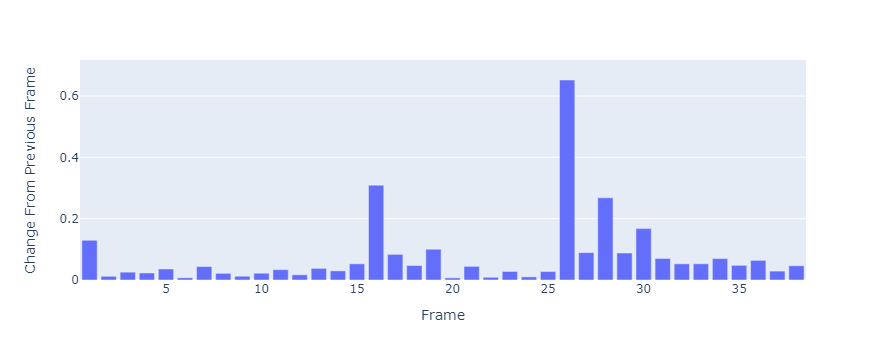

In [35]:
# SPOOF
# Indicating where your diffusion image sequence is
image_folder = Path("D:\\Personal-Study\\Programming\\sd-prompt-graph\\stable-diffusion\\outputs\\txt2img-samples\\All Seeing Eye of God")
path_to_img_folder = image_folder
distance_method = "clip_embeddings"
generate_prompt_graph_image_difference_plotly_fig(image_folder, distance_method=distance_method)

# Experimentation

### Averaging Many Images
I've got a folder of about ~40 similar images. What does their "average" look like? 

In [ ]:
# Indicate the path to a folder with a lot of images
image_folder_path = "C:\\Data\\Personal Study\\Programming\\latent-clustering\\img_experiment_folders\\clip_sim_and_color_sim_interpolation"

# Calculate latents from each of the images in this folder, and return the average image latent
avg_folder_latent = average_img_latents_from_img_folder(image_folder_path)

# Display the image corresponding with this average latent
latent_2_img(img_latent_ndarray=avg_folder_latent, display_image=True, delete_file=True)

Well... that's a little disappointing, but not unexpected. 

### Prompt Graph - Initial Generation and Latent Recursion
First, I'm going to launch the initial generation of the config file. 

In [ ]:
seed = 6
config_path = "C:\\Users\\trevb\\Downloads\\All Seeing Eye of God.json"
output_path = launch_config_generation(config_path, seed=seed)

Next, I'm going to run the latent interpolation.

In [ ]:
output_path / Path("_smoother_interpolations")

In [ ]:
# Run this prompt graph back and forth
prompt_graph_back_and_forth_recursion(output_path, loops=3, pct_change_threshold=0.045, early_stop=2,
                                      seed=seed, distance_metric="latents", new_folder_suffix="smoother_interpolations")

In [ ]:
# Run this prompt graph back and forth
prompt_graph_back_and_forth_recursion(str(output_path)+"_smoother_interpolations", loops=3, pct_change_threshold=0.03, early_stop=2,
                                      seed=seed, distance_metric="latents", new_folder_suffix="smoother_interpolations")

### OpenCLIP Encoding

In [ ]:
# Indicating which image we want to encode
image_to_encode_path_list = ["D:\\Personal-Study\\Programming\\sd-prompt-graph\\stable-diffusion\\outputs\\txt2img-samples\\All Seeing Eye of God\\0.png",
                             "D:\\Personal-Study\\Programming\\sd-prompt-graph\\stable-diffusion\\outputs\\txt2img-samples\\All Seeing Eye of God\\1.png"]

img_to_encode_embedding_dict = image_path_list_to_clip_embedding_dict(image_to_encode_path_list)

In [ ]:

cosine(img_to_encode_embedding_dict["0"][0], img_to_encode_embedding_dict["0"][0])

In [ ]:
img_to_encode_embedding_dict["0"].shape

### Miscellaneous
Any random code can be found below! 

In [ ]:
pic_1 = "C:\\Data\\Personal Study\\Programming\\sd-prompt-graph\\stable-diffusion\\outputs\\img2img-samples\\latent2img_outputImg.png"
pic_2 = "C:\\Data\\Personal Study\\Programming\\stable-diffusion\\stable-diffusion-basujindal\\outputs\\txt2img-samples\\donwood seed experiment\\28.png"
latent_2_img(img_latent_ndarray=average_img_latents_from_path_list([pic_1, pic_2]), 
             display_image=True, delete_file=False)